In [0]:
import numpy as np
from tensorflow.keras.datasets import mnist

import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.utils import to_categorical

%matplotlib inline



In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float')/255.
x_test = x_test.astype('float')/255.


11493376/11490434 [==============================] - 0s 0us/step


In [3]:
x_train.shape

(60000, 28, 28)

In [0]:
x_train = np.reshape(x_train, (60000, 784))
x_test = np.reshape(x_test, (10000, 784))


In [5]:
x_train.shape

(60000, 784)

In [0]:
x_train_noised = x_train + np.random.rand(60000, 784) * 0.9
x_test_noised = x_test + np.random.rand(10000, 784) * 0.9

x_train_noised = np.clip(x_train_noised, 0. ,1. )
x_test_noised = np.clip(x_test_noised, 0. ,1. )

In [0]:
def plot(x, y, labels = False):
  plt.figure(figsize = (20, 2))
  for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(x[i].reshape(28, 28), cmap = 'binary')
    plt.xticks([])
    plt.yticks([])
    if labels:
      plt.xlabel(np.argmax(y[i]))
  plt.show()
  return

   

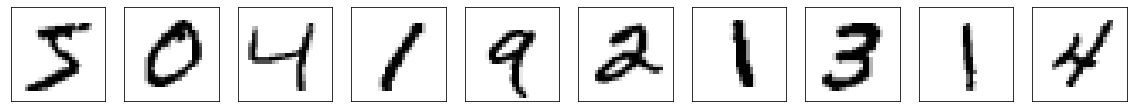

In [8]:
plot(x_train, None)  

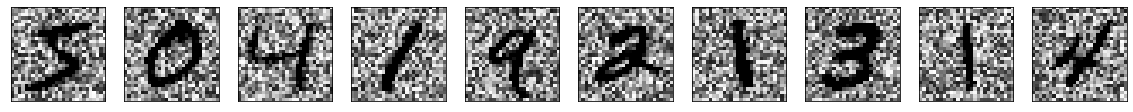

In [9]:
plot(x_train_noised, None)  

In [12]:
#Model to classify any input image - Gives low acc on noised img, hence denoise using a AE and increase accuracy
classifier = Sequential([
                         Dense(256, activation = 'relu', input_shape = (784, )),
                         Dense(256, activation = 'relu'),
                         Dense(10, activation = 'softmax')
])

classifier.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
classifier.fit(x_train, y_train, epochs = 4)

Epoch 1/4
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1962 - accuracy: 0.9404
Epoch 2/4
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0824 - accuracy: 0.9740
Epoch 3/4
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0555 - accuracy: 0.9825
Epoch 4/4
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0430 - accuracy: 0.9858


In [13]:
loss, accuracy = classifier.evaluate(x_test, y_test)
print(accuracy)

313/313 [==============================] - 1s 2ms/step - loss: 0.0815 - accuracy: 0.9770
0.9769999980926514


In [14]:
loss, accuracy = classifier.evaluate(x_test_noised, y_test)
print(accuracy)

313/313 [==============================] - 1s 2ms/step - loss: 2.4662 - accuracy: 0.4098
0.4097999930381775


In [0]:
#Basic autoencoder architecture

input_image = Input(shape = (784,))
encoder = Dense(64, activation = 'relu')(input_image)
decoder = Dense(784, activation = 'sigmoid')(encoder)

autoencoder = Model(input_image, decoder)
autoencoder.compile(loss = 'binary_crossentropy', optimizer = 'adam')

In [16]:
autoencoder.fit(
    x_train_noised, x_train, epochs = 100, batch_size = 512, validation_split = 0.2,
    verbose = False, callbacks = [
                                  EarlyStopping(monitor = 'val_loss', patience = 5),
                                  LambdaCallback(on_epoch_end = lambda e, l: print('{:.3f}'.format(l['val_loss']), end=' _ '))

    ]

)

print(' _ ')
print('Training is complete!')

0.258 _ 0.226 _ 0.199 _ 0.182 _ 0.170 _ 0.161 _ 0.154 _ 0.148 _ 0.142 _ 0.138 _ 0.134 _ 0.131 _ 0.128 _ 0.126 _ 0.124 _ 0.122 _ 0.120 _ 0.119 _ 0.117 _ 0.116 _ 0.115 _ 0.114 _ 0.113 _ 0.113 _ 0.112 _ 0.111 _ 0.111 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.109 _ 0.109 _ 0.109 _ 0.109 _ 0.109 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _  _ 
Training is complete!


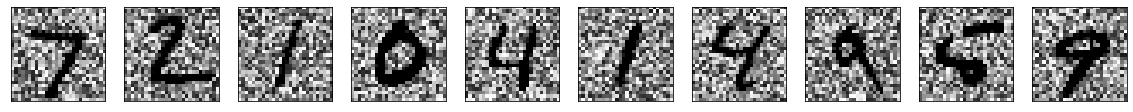

In [17]:
preds = autoencoder.predict(x_test_noised)
plot(x_test_noised, None)

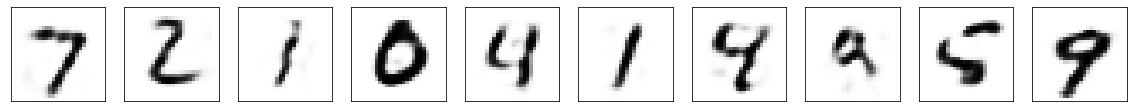

In [18]:
plot(preds, None)

In [19]:
loss, acc = classifier.evaluate(preds, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.1720 - accuracy: 0.9511


In [20]:
print(acc)

0.9510999917984009


In [0]:
#Overall model to classify a noisy image
noisy_image = Input(shape=(784,))
x = autoencoder(noisy_image)
y = classifier(x)

denoise_and_classify = Model(noisy_image, y)

In [0]:
p = denoise_and_classify.predict(x_test_noised)

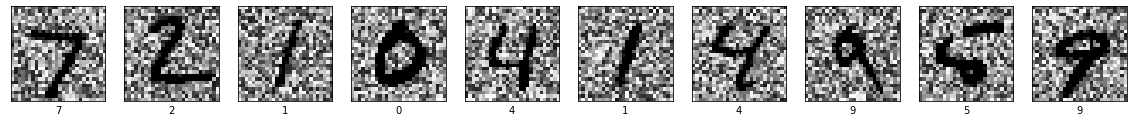

In [24]:
plot(x_test_noised, p, True)

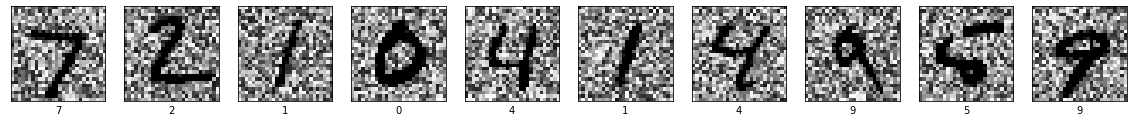

In [25]:
plot(x_test_noised, to_categorical(y_test), True)